# Subwavelength polarizing diffraction gratings with **conformal** coating

In this notebook I am going to test sinusoidal structures with a coating on top

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import hickle as hkl
from pprint import  pprint
import copy

np.set_printoptions(precision=3)

In [4]:
from py_lipss.old.pyS4 import simS4, nanoxz
from py_lipss.old.utils import plotters, numpyhacks

from py_lipss.old.polarization_parameters import polarization_reflection_experiment
from py_lipss.old.computation import compute_3_structures
from py_lipss.old.utils_drawing import plot_Jones_ellipses_in_out, plot2D_E2H2, plot2D_eps

## Conformal coating

In [5]:
# Defining parameters
um = 1.
mm = 1e3
nm = 1e-3

a = 0.580 * um  #[\mu m] lattice parameter in microns
#H = 0.3427 * mu  #[\mu m] Thickness of the grating
#w = 5. #[\mu m] width of the prism
wavelength = 0.85 * um  #[\mu m] incident wavelength

G = 21  # 51 Truncation in k-space
NP = 70  # resolution of the fields
NL =  15 # Even number for perfect alignment
H = 0.4288 * um
coating = 0.45 * um 
Ht = coating  +  H
Hi = Ht/NL

options = {"PolarizationDecomposition": False, "Verbosity": 0}

In [6]:
nsteel = 2.75088646
ksteel = 3.87804413

epssteel = nsteel**2 - ksteel**2 + 2 * nsteel * ksteel * 1j
materials = {"Vacuum": 1.0, "Steel": epssteel, "SiO2":1.44**2}

In [7]:
layers =  [{"Name":"l0", "Thickness":0, "Material":"Vacuum"}]
for iii in range(1,NL+1):
    layers.append({"Name":"l{}".format(iii), "Thickness":Hi, "Material":"Vacuum"})
    
layers.append({"Name":"l{}".format(iii+1), "Thickness":0., "Material":"Steel"})


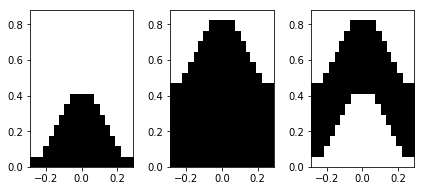

In [8]:
A = H / Ht 
H_cover = coating / Ht
outer =numpyhacks.LUT_cos(NL, 1.,  A, offset= H_cover)    
inner =numpyhacks.LUT_cos(NL, 1.,  A, )    
mater_lut_coating = {"Vacuum":0, "SiO2":1}
mater_lut_inner = {"Vacuum":0, "Steel":1}
layers_pat = range(1,NL+1)

fg, axes = plt.subplots(nrows=1,ncols=3)
params = {"extent":[-a/2,a/2,0, Ht], "cmap":"binary"}
axes[0].imshow(inner, **params)
axes[1].imshow(outer, **params)
axes[2].imshow(outer^inner, **params)
fg.tight_layout()

In [9]:
# Define the structure using py_lipss
grating = nanoxz.NanoArray2D(a, G=G, options=options)
grating.set_materials(materials=materials)
grating.set_layers(layers)

grating.add_pattern(outer, range(1,NL+1), mater_lut_coating)
grating.add_pattern(inner, range(1,NL+1), mater_lut_inner)
grating.set_excite(wavelength)
#orders_list = grating.orders_list

talbot_length = a**2 / wavelength
#z = np.linspace(-0.1*(talbot_length), 0.1*(talbot_length)+ H, NP)
z = np.linspace(-2., Ht + 2., NP)
x = np.linspace(-a / 2, a / 2., NP)

grating.get_fluxes()
#grating.get_amps()
grating.get_fields(x=x, y=[0], z=z)
grating.get_epsilon(x=x, y=[0], z=z)
grating.a = grating._a
grating.z = z

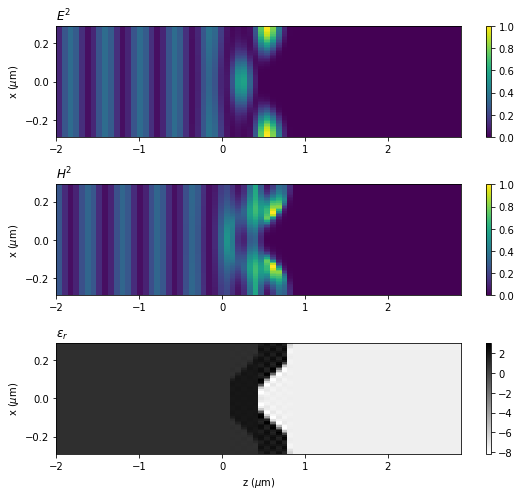

In [10]:
fg = plotters.plot2D_E2H2Eps(grating)

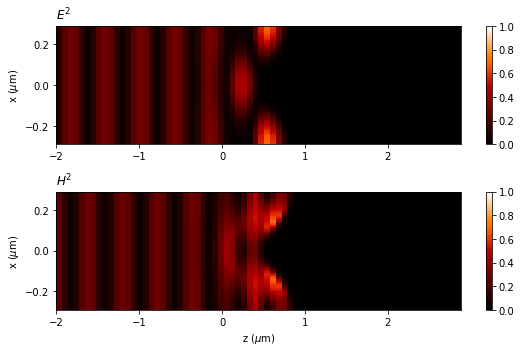

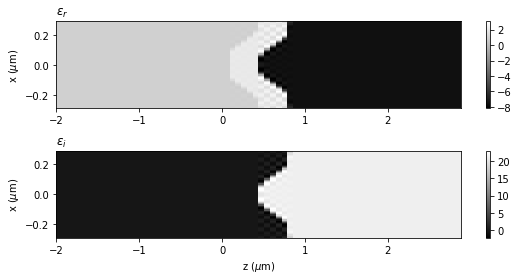

In [11]:
plot2D_E2H2(grating)
plot2D_eps(grating)

In [20]:
#TEMPORAL FIX
grating.sim_info.add('patterns')

In [21]:
# Setting the nanostructure to test
grating.sim_info
grt = copy.deepcopy(grating)
grt.stop(clear_results=True)
grt.source['pAmplitude'] = 1. / np.sqrt(2)
grt.source['sAmplitude'] = 1. / np.sqrt(2.)
grt.get_fields(0, 0, z=np.linspace(-200 * wavelength, -198. * wavelength, NP))
grt.get_fluxes()
grt.start(run_calcs=True)

In [22]:
grt, grt0, grt00 = compute_3_structures(grt)

In [23]:
grt.fluxes.sum(axis=1)[0,1]

(-0.1269385203966242+2.1684043449710093e-19j)

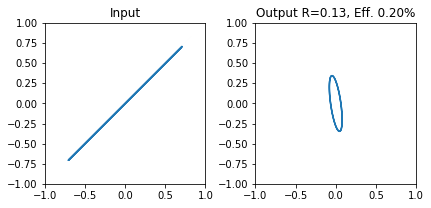

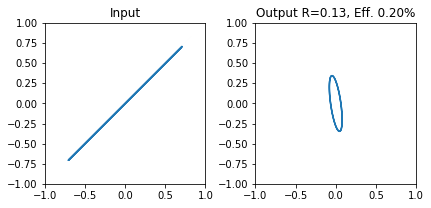

In [28]:
plot_Jones_ellipses_in_out(grt, grt00, grt0)

### Map heights

In [29]:
NP_map = 30 # 30
Hs = np.linspace(0.0, 1., NP_map)
Cs = np.linspace(0.0, 1., NP_map)
stokes_map = np.zeros((NP_map,NP_map,3))
R_map = np.zeros((NP_map,NP_map))
eta_map = np.zeros((NP_map, NP_map))

In [30]:
#%px reload(structures.simS4)
xds = []
for i, h in enumerate(Hs):
    for j, cc in enumerate(Cs):
        #grt = copy.deepcopy(grating)
        grt.stop()
        grt.patterns = []
        D =numpyhacks.LUT_cos(NL, 1.)    
        grt.add_pattern(D, range(2,NL+2), mater_lut_inner)
        for ly in grt.layers[2:NL+2]:
            ly["Thickness"] = h/NL
        grt.layers[1]["Thickness"] = cc
        stks, R0, eta = polarization_reflection_experiment(grt)
        stokes_map[i,j,:] = stks[1:]
        R_map[i,j] = R0
        eta_map[i,j] = eta
        #grt.start()
        #myexp = py_lipss.experiment_class.experiment(
        #    grt, pols=(pols[0], ))
        #myexp.run_experiment()
        #stokes = myexp.get_stokes_z(-10 * l)
        #stokes_map[i, j, :] = stokes[0, 1:]
        #R_map[i, j] = -myexp.exps[0].fluxes[0, :, 1].sum().real

In [1]:
lala = np.array(R_map)
lala = np.concatenate([-R_map[:,:,np.newaxis],eta_map[:,:,np.newaxis]],axis=2)
lala = np.concatenate([np.abs(stokes_map),lala],axis=2)
lala.shape

titles = "I Q V R $\eta$".split()
cmaps = ["Reds_r","Greens_r","Blues_r", "binary", "hot"]
params ={"extent":[0, 1, 0, 1],
         "aspect":'equal',
         "interpolation":'none',
         "origin": 'lower',
         "vmin":0,
         "vmax":1}

xlabel= "Coating (microns)"
ylabel= "Height (microns)"
fg = plotters.imshow_serial(
    lala, (1, 5),
    xlabel= xlabel,
    ylabel= ylabel,
    last_axis=True, 
    figargs={"figsize":(10,20), "dpi":120},
    titles=titles,
    cmaps=cmaps,
    params=params)


NameError: name 'np' is not defined

# Conclusions and further research

As we can see from the figures the modification of the polarization   is modulated with the uniform coating following a $\lambda/2$ rule.